<a href="https://colab.research.google.com/github/Resia05/unsupervised_learning/blob/main/%D0%9A%D0%BE%D0%BF%D1%96%D1%8F_%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BD%D0%B8%D0%BA%D0%B0_%22HW_NLP_Classification_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
import pandas as pd
data = '/content/drive/MyDrive/Colab Notebooks/train.csv.zip'
raw_df = pd.read_csv(data)

In [66]:
pd.set_option('display.max_colwidth', None)
raw_df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


In [67]:
raw_df.describe() #неінформативна статистика для текстових даних.

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [68]:
raw_df.shape

(27481, 4)

In [69]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [70]:
raw_df.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [71]:
df = raw_df.dropna()

In [72]:
df.shape

(27480, 4)

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [73]:
class_counts = df.sentiment.value_counts(normalize=True)

class_counts

,proportion
sentiment,
neutral,0.404549
positive,0.312300
negative,0.283151


<ipython-input-74-2819a56abd1a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


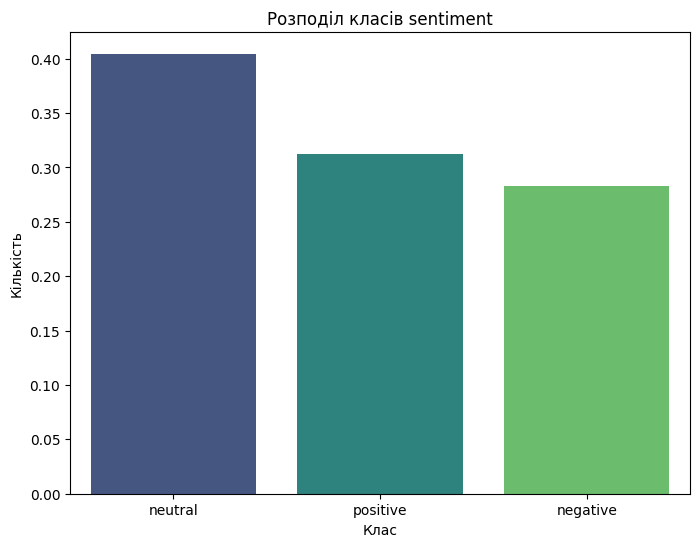

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Розподіл класів sentiment')
plt.xlabel('Клас')
plt.ylabel('Кількість')
plt.show()

<ipython-input-75-c4fada4a6879>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['text'].apply(len)


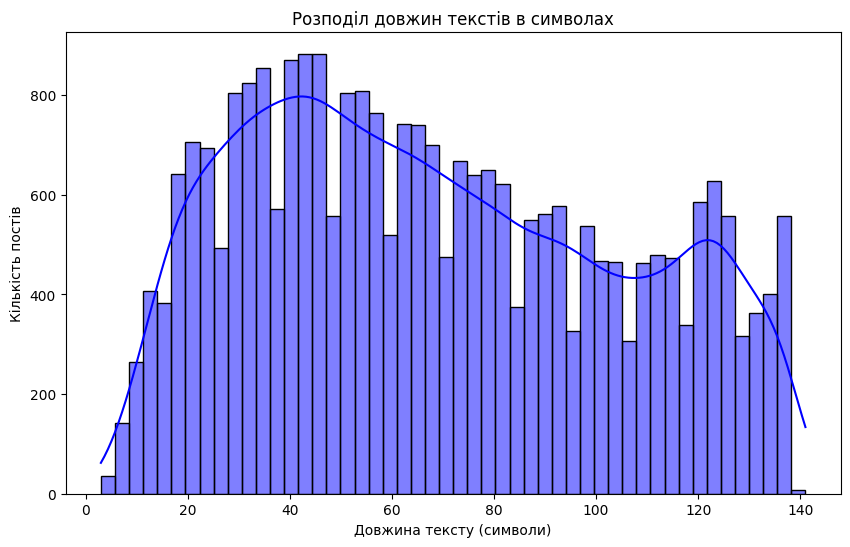

,text_length
count,27480.000000
mean,68.330022
std,35.603870
min,3.000000
25%,39.000000
50%,64.000000
75%,97.000000
max,141.000000


In [75]:
# Додаємо нову колонку з довжиною тексту в символах
df['text_length'] = df['text'].apply(len)

# Візуалізація розподілу довжин текстів
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='blue')
plt.title('Розподіл довжин текстів в символах')
plt.xlabel('Довжина тексту (символи)')
plt.ylabel('Кількість постів')
plt.show()

# Описова статистика довжин текстів
df['text_length'].describe()


Довжина тексту досить схожа, практично немає викидів, за виключенням min / max довжини.

In [76]:
df

,textID,text,selected_text,sentiment,text_length
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46
2,088c60f138,my boss is bullying me...,bullying me,negative,25
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,75
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband lost his job and can`t afford it,d lost,negative,77
27477,4f4c4fc327,"I`ve wondered about rake to. The client has made it clear .NET only, don`t force devs to learn a new lang #agile #ccnet",", don`t force",negative,122
27478,f67aae2310,Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend Take care hun xxxx,Yay good for both of you.,positive,111
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,27


### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [77]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-78-f9273979a5ab>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(preprocess_text)


     word  count
438    im   3059
219   day   2414
361  good   1569
969  work   1483
523  love   1458


<Figure size 1000x600 with 0 Axes>

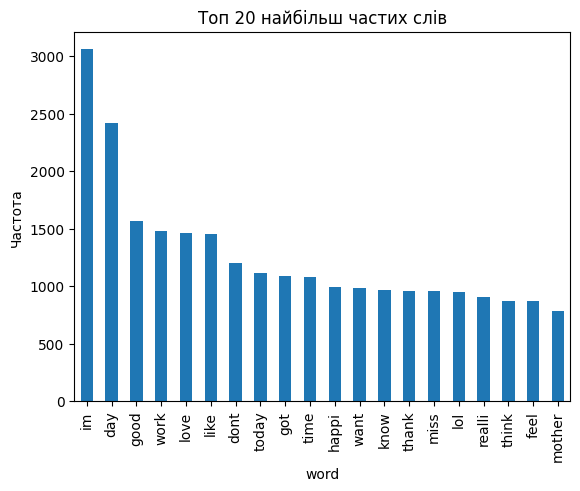

In [78]:
# Завантажуємо стоп-слова
nltk.download('stopwords')

# Ініціалізація стеммера та стоп-слів
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

# Функція для попередньої обробки тексту
def preprocess_text(text):
    text = text.lower()  # Переведемо текст у нижній регістр
    text = re.sub(r'[^a-z\s]', '', text)  # Видаляємо все, що не є літерами або пробілами
    words = text.split()  # Розбиваємо текст на слова
    words = [stemmer.stem(word) for word in words if word not in stop_words]  # Видаляємо стоп-слова і стемінг
    return ' '.join(words)

# Попередня обробка тексту
df['clean_text'] = df['text'].apply(preprocess_text)

# Векторизація
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])

# Отримуємо всі слова та їх частоти
word_counts = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()

# Створюємо DataFrame для аналізу
word_freq_df = pd.DataFrame({'word': words, 'count': word_counts}).sort_values(by='count', ascending=False)

# Виводимо кілька найбільш частих слів
print(word_freq_df.head())

# Візуалізація частотності слів
plt.figure(figsize=(10, 6))
word_freq_df.head(20).plot(kind='bar', x='word', y='count', legend=False)
plt.title('Топ 20 найбільш частих слів')
plt.ylabel('Частота')
plt.show()


     word  count
213   day   2414
357    go   2363
349   get   1909
363  good   1569
966  work   1483


<Figure size 1000x600 with 0 Axes>

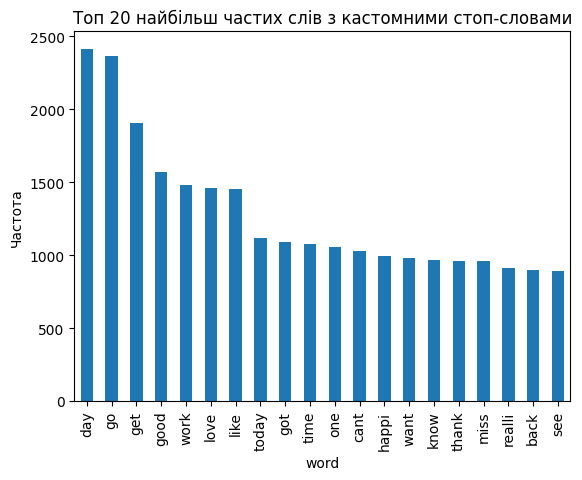

In [79]:
# Додаємо кастомні стоп-слова
custom_stop_words = ['im', 'dont', 'lol']

# Оновлюємо векторизатор з кастомними стоп-словами
vectorizer = CountVectorizer(max_features=1000, stop_words=custom_stop_words)
X = vectorizer.fit_transform(df['clean_text'])

# Отримуємо всі слова та їх частоти
word_counts = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()

# Створюємо DataFrame для аналізу
word_freq_df = pd.DataFrame({'word': words, 'count': word_counts}).sort_values(by='count', ascending=False)

# Виводимо кілька найбільш частих слів
print(word_freq_df.head())

# Візуалізація частотності слів з кастомними стоп-словами
plt.figure(figsize=(10, 6))
word_freq_df.head(20).plot(kind='bar', x='word', y='count', legend=False)
plt.title('Топ 20 найбільш частих слів з кастомними стоп-словами')
plt.ylabel('Частота')
plt.show()


In [63]:
df

,textID,text,selected_text,sentiment,text_length,clean_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,id respond go
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,25,boss bulli
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,interview leav alon
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,75,son couldnt put releas alreadi bought
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband lost his job and can`t afford it,d lost,negative,77,wish could come see u denver husband lost job cant afford
27477,4f4c4fc327,"I`ve wondered about rake to. The client has made it clear .NET only, don`t force devs to learn a new lang #agile #ccnet",", don`t force",negative,122,ive wonder rake client made clear net dont forc dev learn new lang agil ccnet
27478,f67aae2310,Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend Take care hun xxxx,Yay good for both of you.,positive,111,yay good enjoy break probabl need hectic weekend take care hun xxxx
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,27,worth


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [83]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Векторизація текстів
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])
y = df['sentiment']

# Створення списку індексів
indices = np.arange(X.shape[0])

# Розділення індексів на навчальні та тестові
X_train_idx, X_test_idx = train_test_split(indices, test_size=0.3, random_state=42, stratify=y)

# Формування навчальних та тестових наборів
X_train_bow = X[X_train_idx]
X_test_bow = X[X_test_idx]
y_train = y.iloc[X_train_idx]
y_test = y.iloc[X_test_idx]

# Навчання моделей
# Логістична регресія
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_bow, y_train)
lr_predictions = lr_model.predict(X_test_bow)

# Дерево рішень
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_bow, y_train)
dt_predictions = dt_model.predict(X_test_bow)

# Оцінка якості класифікації
def evaluate_model(predictions, y_true):
    print(f"Accuracy: {accuracy_score(y_true, predictions)}")
    print("Classification Report:")
    print(classification_report(y_true, predictions))

print("Logistic Regression:")
evaluate_model(lr_predictions, y_test)

print("Decision Tree:")
evaluate_model(dt_predictions, y_test)


Logistic Regression:
Accuracy: 0.6877729257641921
Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.59      0.64      2334
     neutral       0.63      0.75      0.68      3335
    positive       0.77      0.70      0.73      2575

    accuracy                           0.69      8244
   macro avg       0.70      0.68      0.69      8244
weighted avg       0.70      0.69      0.69      8244

Decision Tree:
Accuracy: 0.6209364386220282
Classification Report:
              precision    recall  f1-score   support

    negative       0.58      0.60      0.59      2334
     neutral       0.60      0.60      0.60      3335
    positive       0.68      0.67      0.68      2575

    accuracy                           0.62      8244
   macro avg       0.62      0.62      0.62      8244
weighted avg       0.62      0.62      0.62      8244



In [84]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Створюємо LabelEncoder для y_train та y_test
label_encoder = LabelEncoder()

# Закодуємо y_train та y_test
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Виведемо відповідність між текстовими і числовими категоріями
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Відповідність між текстовими та числовими категоріями:", class_mapping)

# Тренування XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_bow, y_train_encoded)

# Прогнозування на тестових даних
y_pred_xgb = xgb.predict(X_test_bow)

# Оцінка XGBoost
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred))

print("XGBoost:")
evaluate_model(y_test_encoded, y_pred_xgb, "XGBoost")


Відповідність між текстовими та числовими категоріями: {'negative': 0, 'neutral': 1, 'positive': 2}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:31:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
XGBoost Accuracy: 0.6876516254245512
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.53      0.63      2334
           1       0.62      0.79      0.69      3335
           2       0.77      0.70      0.73      2575

    accuracy                           0.69      8244
   macro avg       0.71      0.67      0.68      8244
weighted avg       0.70      0.69      0.69      8244



XGBoost є найкращою моделлю за загальною точністю (Accuracy) та в усіх важливих метриках для класів Neutral та Positive. Логістична регресія, з іншого боку, має найкращі показники для класу Negative.

У загальному випадку, XGBoost має найвищу точність та краще справляється з більшістю класів, тому її можна вважати найкращою моделлю з цих трьох.

Загалом модель працює нормально, але можна було б покращити її результати. Детальін рекомендації вкінці роботи.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


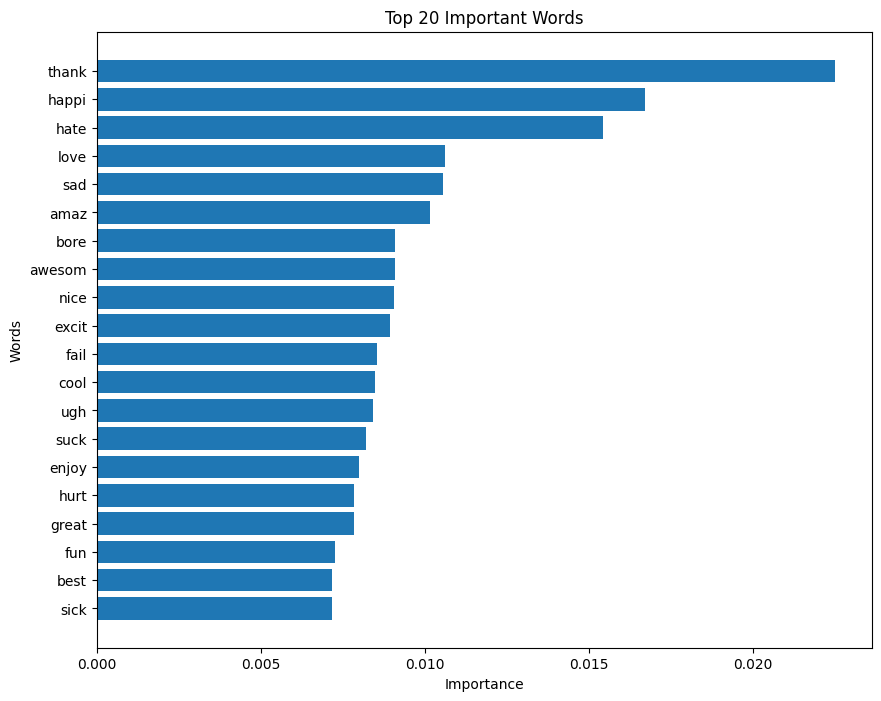

In [86]:
# Отримання важливостей ознак
importances = xgb.feature_importances_

# Отримання слів з CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Створення DataFrame для важливостей
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Сортування за важливістю
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Візуалізація важливих слів
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20))
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title('Top 20 Important Words')
plt.gca().invert_yaxis()
plt.show()

In [87]:
importance_df.head(20)

,Feature,Importance
863,thank,0.022508
390,happi,0.016713
392,hate,0.015439
523,love,0.010619
722,sad,0.010563
28,amaz,0.010166
103,bore,0.009096
58,awesom,0.009095
591,nice,0.009050
284,excit,0.008939


Загалом все виглядає логічно.

Позитивні Слова: Переважають у списку і, як очікується, мають високу важливість для позитивного сентименту. Вони використовуються для вираження позитивних емоцій і ставлення.

Негативні Слова: Також присутні у списку і мають високу важливість для негативного сентименту. Це логічно, оскільки ці слова безпосередньо виражають негативні емоції.

Неоднозначні Слова: Можуть мати як позитивний, так і негативний контекст в залежності від контексту їх використання.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Ініціалізація TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Векторизація текстів
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

# Отримання всіх слів та їх TF-IDF значень
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_tfidf.mean(axis=0).A1

# Створюємо DataFrame для аналізу
tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf_score': tfidf_scores}).sort_values(by='tfidf_score', ascending=False)

# Виведемо кілька найбільш впливових слів
print(tfidf_df.head())


     word  tfidf_score
438    im     0.029721
219   day     0.025747
969  work     0.019105
361  good     0.019048
523  love     0.018313


In [91]:
# Перекодування міток
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Перевірка розмірів даних
print("Розмір X_train_tfidf:", X_train_tfidf.shape)
print("Розмір y_train_encoded:", y_train_encoded.shape)
print("Розмір X_test_tfidf:", X_test_tfidf.shape)
print("Розмір y_test_encoded:", y_test_encoded.shape)

# Створення класифікатора
xgb_tfidf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Тренування класифікатора
xgb_tfidf.fit(X_train_tfidf, y_train_encoded)

# Прогнозування на тестових даних
y_pred_xgb_tfidf = xgb_tfidf.predict(X_test_tfidf)

# Оцінка XGBoost з TF-IDF
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred))

print("XGBoost (TF-IDF):")
evaluate_model(y_test_encoded, y_pred_xgb_tfidf, "XGBoost (TF-IDF)")

Розмір X_train_tfidf: (21984, 1000)
Розмір y_train_encoded: (21984,)
Розмір X_test_tfidf: (5496, 1000)
Розмір y_test_encoded: (5496,)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:41:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (TF-IDF):
XGBoost (TF-IDF) Accuracy: 0.7019650655021834
XGBoost (TF-IDF) Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.53      0.63      1572
           1       0.63      0.80      0.71      2236
           2       0.78      0.73      0.75      1688

    accuracy                           0.70      5496
   macro avg       0.73      0.69      0.70      5496
weighted avg       0.72      0.70      0.70      5496



XGBoost:
XGBoost Accuracy: 0.6876516254245512
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.53      0.63      2334
           1       0.62      0.79      0.69      3335
           2       0.77      0.70      0.73      2575

    accuracy                           0.69      8244


З використанням TF-IDF точність і метрики класифікації в цілому покращилися, що свідчить про більшу ефективність векторизації. Зважаючи на ці результати, TF-IDF виявляється кращим вибором для даної задачі класифікації, оскільки забезпечує вищу якість класифікації.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [94]:
# Знаходження помилкових прогнозів
incorrect_predictions = X_test_tfidf[y_pred_xgb_tfidf != y_test_encoded]
incorrect_labels = y_test_encoded[y_pred_xgb_tfidf != y_test_encoded]

# Створення DataFrame з помилковими прогнозами
error_analysis_df = pd.DataFrame({
    'Text': incorrect_predictions,
    'True Label': incorrect_labels,
    'Predicted Label': y_pred_xgb_tfidf[y_pred_xgb_tfidf != y_test_encoded]
})

# Виведення кількох прикладів
error_analysis_df.head(20)

,Text,True Label,Predicted Label
0,"(0, 481)\t0.5898323847158146\n (0, 905)\t0.5760267397293594\n (0, 131)\t0.5659425351192647",0,1
1,"(0, 65)\t0.46918314146646617\n (0, 644)\t0.44017885751289704\n (0, 921)\t0.4208613299106908\n (0, 382)\t0.447803936383034\n (0, 187)\t0.45657105548639737",1,0
2,"(0, 225)\t0.40448708520336024\n (0, 517)\t0.32175433631123845\n (0, 588)\t0.2732755714693886\n (0, 336)\t0.3661730890427436\n (0, 927)\t0.41414365005285875\n (0, 814)\t0.363311357088315\n (0, 173)\t0.27993424584595894\n (0, 519)\t0.2721805506343949\n (0, 696)\t0.26104891621711857",2,1
3,"(0, 969)\t0.7497339496071783\n (0, 219)\t0.6617393783102387",0,1
4,"(0, 175)\t0.8383091013102285\n (0, 961)\t0.5451952408637081",0,2
5,"(0, 84)\t0.7943510577455769\n (0, 969)\t0.6074589673866729",0,1
6,"(0, 980)\t0.500584630874885\n (0, 441)\t0.5511733466607602\n (0, 402)\t0.46221775780903535\n (0, 216)\t0.4816406478160045",2,1
7,"(0, 89)\t1.0",2,1
8,"(0, 669)\t0.5041616496311578\n (0, 77)\t0.4770426939300794\n (0, 728)\t0.43379182071555034\n (0, 308)\t0.2929808342696709\n (0, 450)\t0.4379591393204665\n (0, 219)\t0.22897593438117841",2,0
9,"(0, 708)\t0.4384777425282045\n (0, 241)\t0.4443418297615685\n (0, 401)\t0.3799719689545746\n (0, 588)\t0.2749036495095149\n (0, 889)\t0.3683546172413681\n (0, 750)\t0.4475097348936037\n (0, 504)\t0.23323123088271513",0,1


In [100]:
# Аналіз помилок
error_indices = y_pred_xgb_tfidf != y_test_encoded

# Перевіряємо довжину масивів
num_errors = error_indices.sum()  # Кількість помилок
error_analysis_df = pd.DataFrame({
    'Text': [original_texts[i] for i in range(len(y_test_encoded)) if error_indices[i]],
    'True Label': y_test_encoded[error_indices],
    'Predicted Label': y_pred_xgb_tfidf[error_indices]
})

error_analysis_df.head(50)

# Відповідність між текстовими та числовими категоріями: {'negative': 0, 'neutral': 1, 'positive': 2}

,Text,True Label,Predicted Label
0,Sooo SAD I will miss you here in San Diego!!!,0,1
1,Both of you,1,0
2,i want to go to music tonight but i lost my voice.,2,1
3,"i`ve been sick for the past few days and thus, my hair looks wierd. if i didnt have a hat on it would look... http://tinyurl.com/mnf4kw",0,1
4,Playing Ghost Online is really interesting. The new updates are Kirin pet and Metamorph for third job. Can`t wait to have a dragon pet,0,2
5,I`m sorry.,0,1
6,Went to sleep and there is a power cut in Noida Power back up not working too,2,1
7,"Thats it, its the end. Tears for Fears vs Eric Prydz, DJ Hero http://bit.ly/2Hpbg4",2,1
8,i`m soooooo sleeeeepy!!! the last day o` school was today....sniffle....,2,0
9,im an avid fan of **** magazine and i love your magazines,0,1


Аналіз помилок класифікації може вказувати на кілька причин, чому класифікатор допустив помилки:

Сарказм та іронія: Багато текстів можуть містити сарказм або іронію, що ускладнює їхню класифікацію.

Неправильне використання емоційних слів: Деякі слова можуть мати різні значення залежно від контексту.

Неповні або нечіткі вирази: Деякі тексти можуть бути занадто короткими або не містити достатньо інформації, щоб класифікатор зміг правильно визначити емоцію.

Пропозиції для покращення якості класифікації
Покращення препроцесингу тексту:

Додати більш детальну очистку тексту, наприклад, додати більше слів у перелік стоп-слів. Можливо, свпробувати прибрати з набору даних емоційні слова, так як з аналізу помилок видно, що вони впливають на неправильну класифікацію. Прибрати занадто короткі речення. Видалити знаки, типу знак питання, знак оклику і тд.

Провести налаштування гіперпараметрів моделей. Можливо, варто спробувати різні значення learning_rate, depth дерев, subsample та інші параметри для покращення ефективності моделі. Спробувати комбінувати кілька моделей (наприклад, XGBoost з Logistic Regression або Decision Trees) для досягнення кращих результатів, використовуючи методи ансамблювання, такі як VotingClassifier або StackingClassifier.

Покращення векторизації: Використання більш складних методів векторизації, таких як Word2Vec або BERT, може допомогти моделі краще зрозуміти контекст і семантику слів. Включення додаткових функцій для аналізу тональності, таких як виявлення емоцій або аналіз настрою, може підвищити точність класифікації.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model